In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D , Dropout , Flatten
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
import tensorflow
import random
from tensorflow.keras.models import load_model

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:18<00:00, 173MB/s]
100% 2.29G/2.29G [00:18<00:00, 135MB/s]


In [ ]:
! unzip "/content/chest-xray-pneumonia.zip"

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Data

In [ ]:
os.listdir("/content/chest_xray/chest_xray")

['test', 'val', 'train', '.DS_Store']

In [ ]:
train_path = '/content/chest_xray/train/'
test_path = '/content/chest_xray/test/'
val_path = '/content/chest_xray/val/'


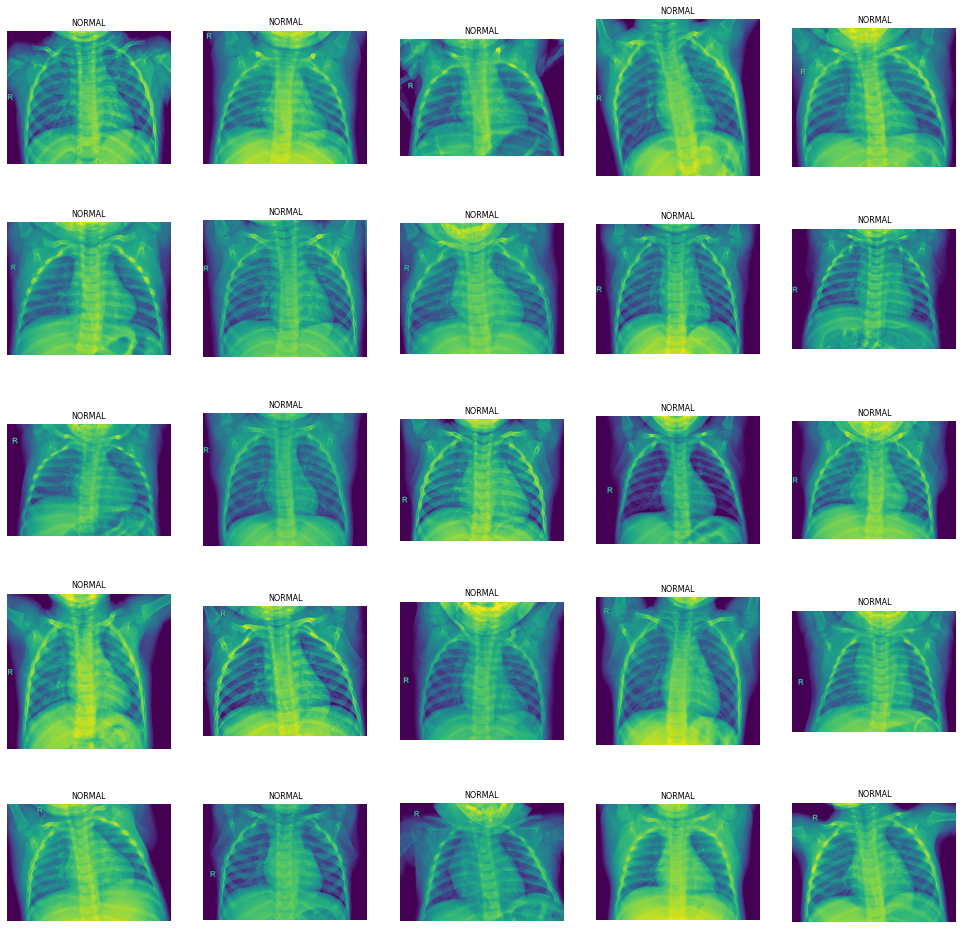

In [ ]:
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() 
for i in np.arange(0, W * H): 
    label ='NORMAL'
    class_dir = os.path.join(train_path,label)
    
    image = random.choice(os.listdir(class_dir))
       
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) 
    axes[i].axis('off')


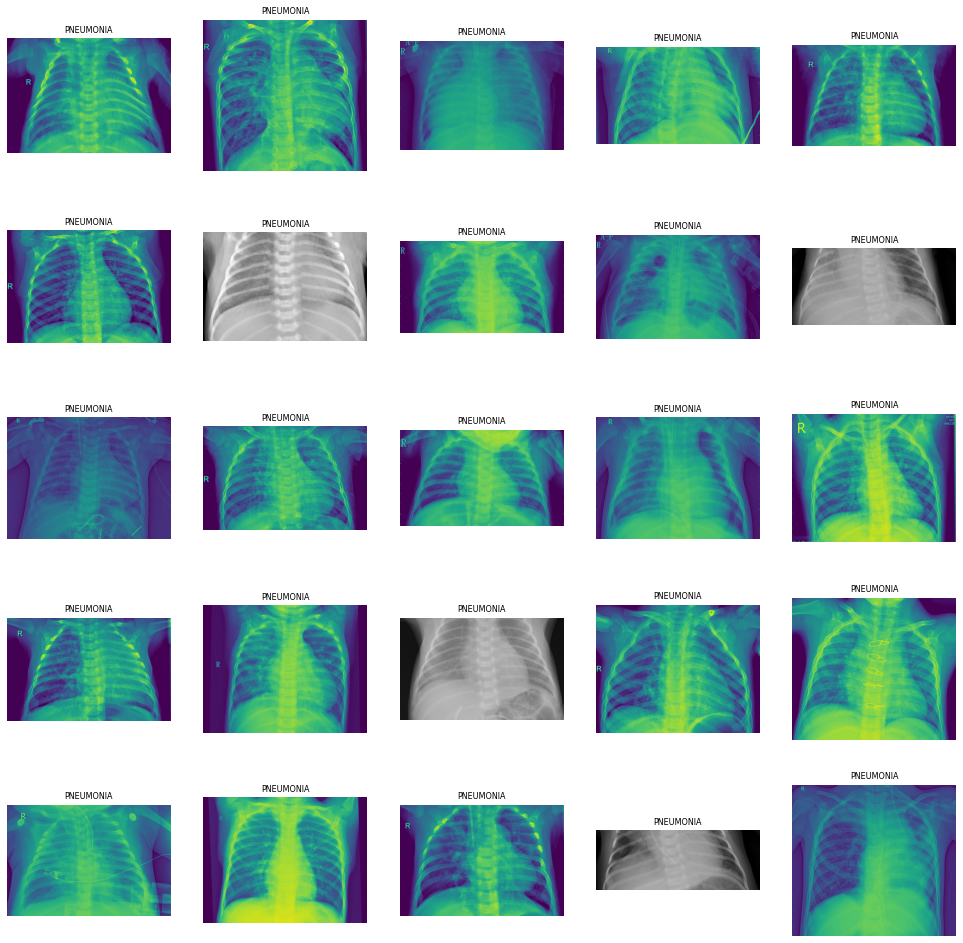

In [ ]:
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() 
for i in np.arange(0, W * H): 
    label ='PNEUMONIA'
    class_dir = os.path.join(train_path,label)
    
    image = random.choice(os.listdir(class_dir))
       
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) 
    axes[i].axis('off')


# Data Augementation

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/chest_xray/train" ,
                                                    target_size = (224 , 224) ,
                                                    class_mode = "binary",
                                                    batch_size = 64)

test_generator = test_datagen.flow_from_directory("/content/chest_xray/test" ,
                                                    target_size = (224 , 224) ,
                                                    class_mode = "binary",
                                                    batch_size = 64)
val_generator = val_datagen.flow_from_directory("/content/chest_xray/val" ,
                                                    target_size = (224 , 224) ,
                                                    class_mode = "binary",
                                                    batch_size = 64)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# MODEL

In [ ]:
ckpt_path  = "/content/drive/MyDrive/Pneumonia_Detection/model_ckpt.h5"
early_stopping_cb = EarlyStopping(patience = 4)
checkpoint_cb = ModelCheckpoint(ckpt_path ,     
                                
                                
)

In [ ]:
base_model = InceptionV3(input_shape = (224  , 224 , 3) , weights = "imagenet" , include_top = False)

In [ ]:
model = Flatten()(base_model.output)
model = Dense(8 , activation = "relu")(model)
model = Dropout(0.2)(model)
model = Dense(1 , activation = "sigmoid")(model)


In [ ]:
from tensorflow.keras.models  import Model

In [ ]:
model = Model(base_model.input , model)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
optimizer = tensorflow.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


Epoch 1/100
82/82 [==============================] - 144s 1s/step - loss: 0.2292 - binary_accuracy: 0.8961 - val_loss: 1.7061 - val_binary_accuracy: 0.6667
Epoch 2/100
82/82 [==============================] - 116s 1s/step - loss: 0.1301 - binary_accuracy: 0.9592 - val_loss: 0.8988 - val_binary_accuracy: 0.7788
Epoch 3/100
82/82 [==============================] - 116s 1s/step - loss: 0.1044 - binary_accuracy: 0.9728 - val_loss: 0.2648 - val_binary_accuracy: 0.9022
Epoch 4/100
82/82 [==============================] - 117s 1s/step - loss: 0.0918 - binary_accuracy: 0.9778 - val_loss: 0.3630 - val_binary_accuracy: 0.8766
Epoch 5/100
82/82 [==============================] - 115s 1s/step - loss: 0.0749 - binary_accuracy: 0.9833 - val_loss: 0.7183 - val_binary_accuracy: 0.8317
Epoch 6/100
82/82 [==============================] - 118s 1s/step - loss: 0.0736 - binary_accuracy: 0.9862 - val_loss: 0.2309 - val_binary_accuracy: 0.9087
Epoch 7/100
82/82 [==============================] - 117s 1s/ste

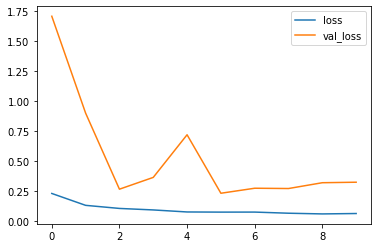

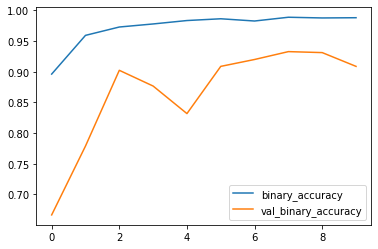

In [ ]:
history = model.fit(
    train_generator , 
    epochs = 100, 
    validation_data = test_generator,
    callbacks = [early_stopping_cb , checkpoint_cb]
)


import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig("/content/drive/MyDrive/Pneumonia_Detection/loss_plot.jpeg")
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
plt.savefig("/content/drive/MyDrive/Pneumonia_Detection/accuracy_plot.jpeg")

In [ ]:
model.evaluate(test_generator)

10/10 [==============================] - 6s 560ms/step - loss: 0.3229 - binary_accuracy: 0.9087


[0.3228748142719269, 0.9086538553237915]

In [ ]:
model.evaluate(val_generator)

1/1 [==============================] - 1s 1s/step - loss: 0.2690 - binary_accuracy: 0.8750


[0.2689949870109558, 0.875]

In [ ]:
model.evaluate(train_generator)

82/82 [==============================] - 101s 1s/step - loss: 0.0311 - binary_accuracy: 0.9887


[0.031117141246795654, 0.9886886477470398]

In [ ]:
model = load_model("/content/drive/MyDrive/Pneumonia_Detection/model_ckpt.h5")


In [ ]:
def pred(img_path):
  img=tensorflow.keras.utils.load_img(img_path,target_size=(224 , 224 ,3))
  x=tensorflow.keras.preprocessing.image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  classes=model.predict(x)
  
  if classes[0][0] == 0:
    print("Normal")
  else:
    print("Pneumonia")

In [ ]:
pred("/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg")

Pneumonia


In [ ]:
pred("/content/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg")

Pneumonia
